In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import re #for extracting place names from titles

import accesses #local file with API certs and database passwords.

#for connecting to databases
import psycopg2
from sqlalchemy import create_engine

import json #for parsing the return from the Google API
import urllib #for passing info to the Google API

In [46]:
# Creat a connection and cursor directly to the database using psycopg2.
conn = psycopg2.connect(host="localhost",database="reddit", user=accesses.db_user, 
                        password=accesses.db_pw)

## Raw Reddit Review and Analysis

In [47]:
c = conn.cursor()
df_raw_reddit = pd.read_sql('select * from raw_reddit', conn, index_col='id')
c.close()

In [48]:
# The API expects no spaces and words concatanated with a '+', which 
# is what this function does.
def convert_address(address):
    converted_address = ''
    try: 
        for word in address.split():
            converted_address += (word + '+')        
        return converted_address[:-1]
    except:
        pass

In [49]:
pat_1 = r'((?:[A-Z]\w+\.*,*\s*\n*){2,})'

places = df_raw_reddit['title'].str.extractall(pat_1).unstack()
# to return the first element, the dataframe
places = places[0]
places = places.rename(columns = {0:'extracted_0',1:'extracted_1'})
places = pd.merge(df_raw_reddit, places, how='left', left_index=True,
                      right_index=True)
places['converted_0'] = places['extracted_0'].apply(convert_address)
places['converted_1'] = places['extracted_1'].apply(convert_address)
places = places.replace({None:np.nan})

### Now we can pull the Geocoded locations from the database

In [50]:
# During testing, multiple runs introduced several duplicates.  Since this
# class focuses on Python, I handled the duplicates here rather than in 
# the database itself.

c = conn.cursor()
# select all rows from the geocoded_addresses table
df_geocoded = pd.read_sql('select * from geocoded_addresses', conn)
# get original length
print(len(df_geocoded))
# drop all duplicates by ID and set index to the id
df_geocoded.drop_duplicates('id', inplace=True)
df_geocoded.set_index('id', inplace=True)
# print length to see how many we removed
print(len(df_geocoded))
c.close()

33979
33952


In [51]:
def build_geo_dict(df):
    geo_dict_list = []
    error_list = {}
    for row in df.iterrows():
        uid = row[0]
        data = (row[1][0])
        geo_dict = {}
        geo_dict['id'] = uid
        
        try:
            geo_dict['lat'] = data['results'][0]['geometry']['location']['lat']
            geo_dict['lon'] = data['results'][0]['geometry']['location']['lng']
            for component in data['results'][0]['address_components']:
                geo_dict[component['types'][0]] = component['long_name']
            geo_dict_list.append(geo_dict)
        
        except: 
            error_list[uid]=data
        
    return (geo_dict_list, error_list)

In [52]:
results, errors = build_geo_dict(df_geocoded)

### And finally, we can analyze!

In [53]:
sns.set(rc={'figure.figsize':(12,8)})

In [54]:
final_full = pd.DataFrame(results)
final_full.set_index('id', inplace=True)

In [55]:
merged = pd.merge(final_full, places, right_index=True, left_index=True, how='left')
final = merged[['country','administrative_area_level_1', 'score', 'title', 'extracted_0',
                'dt_time','lat', 'lon']]

Our scraper got some dates from 2016, so we are going to limit it to 2017 onward only.

In [56]:
final = final[final['dt_time'] > dt.datetime(2017,1,1)]

## Wordcloud

In [57]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

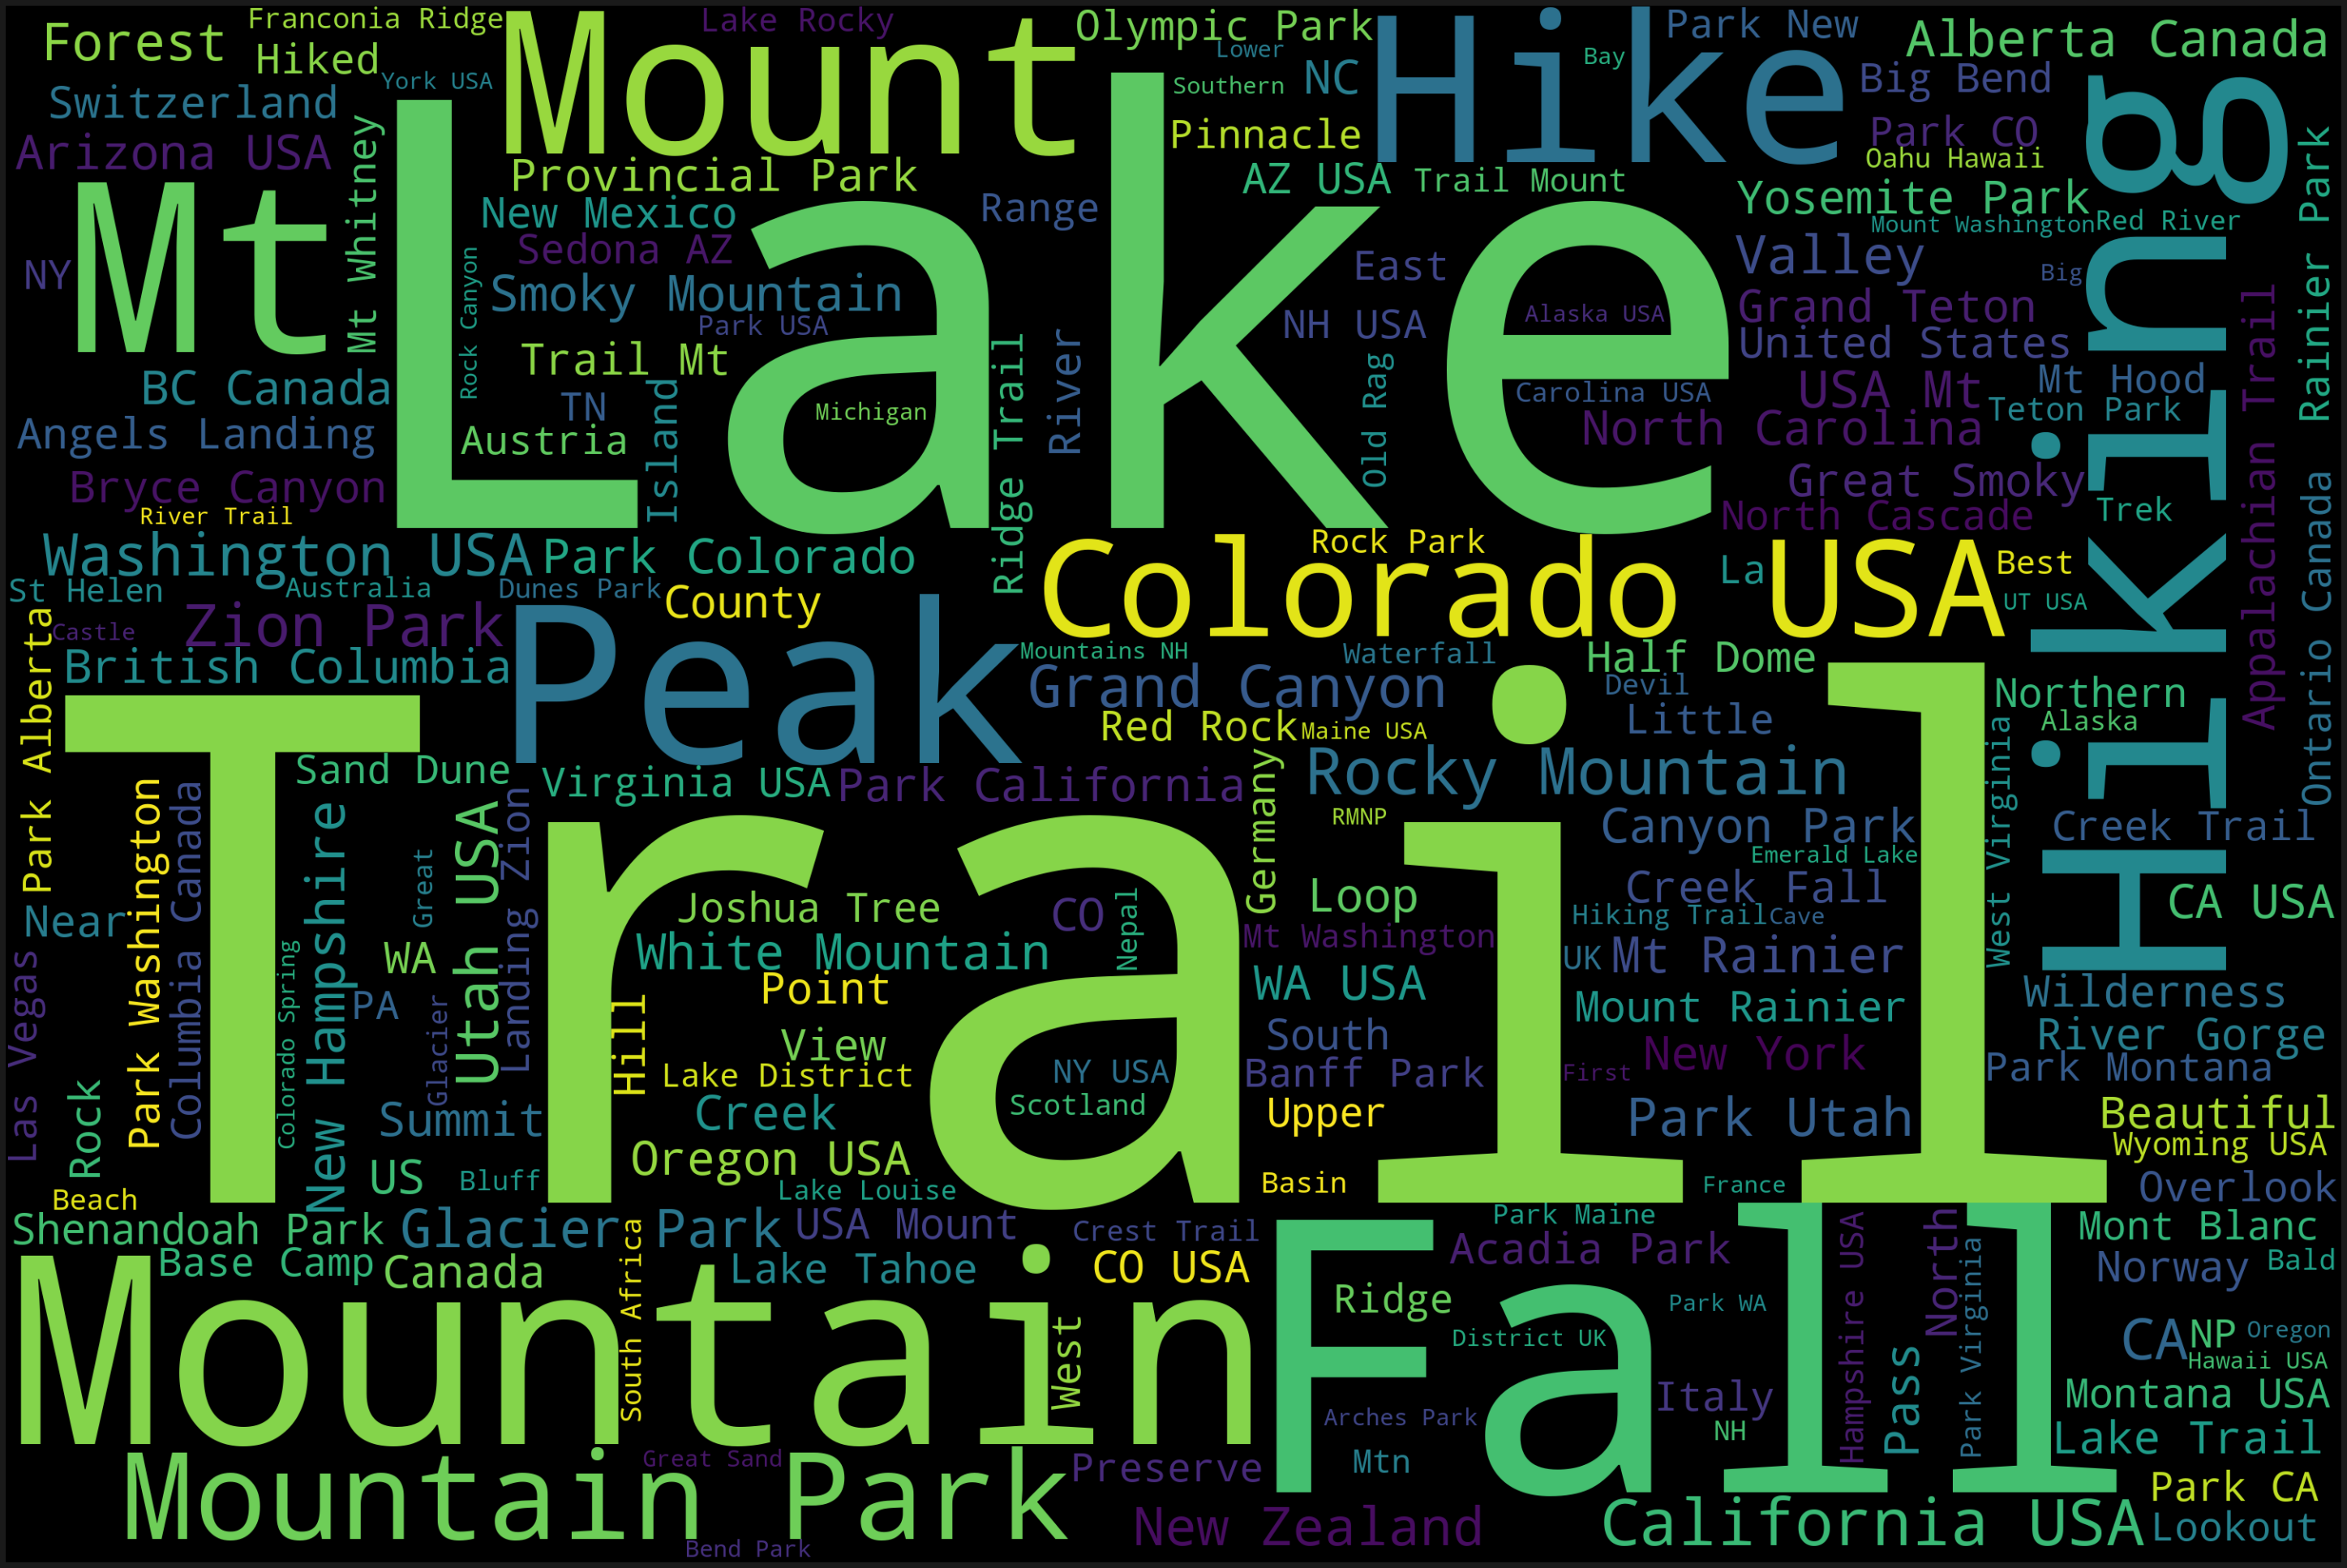

In [58]:
text = " ".join(title for title in final['extracted_0'])
stopwords = set(STOPWORDS)
stopwords.update(["national", "state"])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stopwords).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

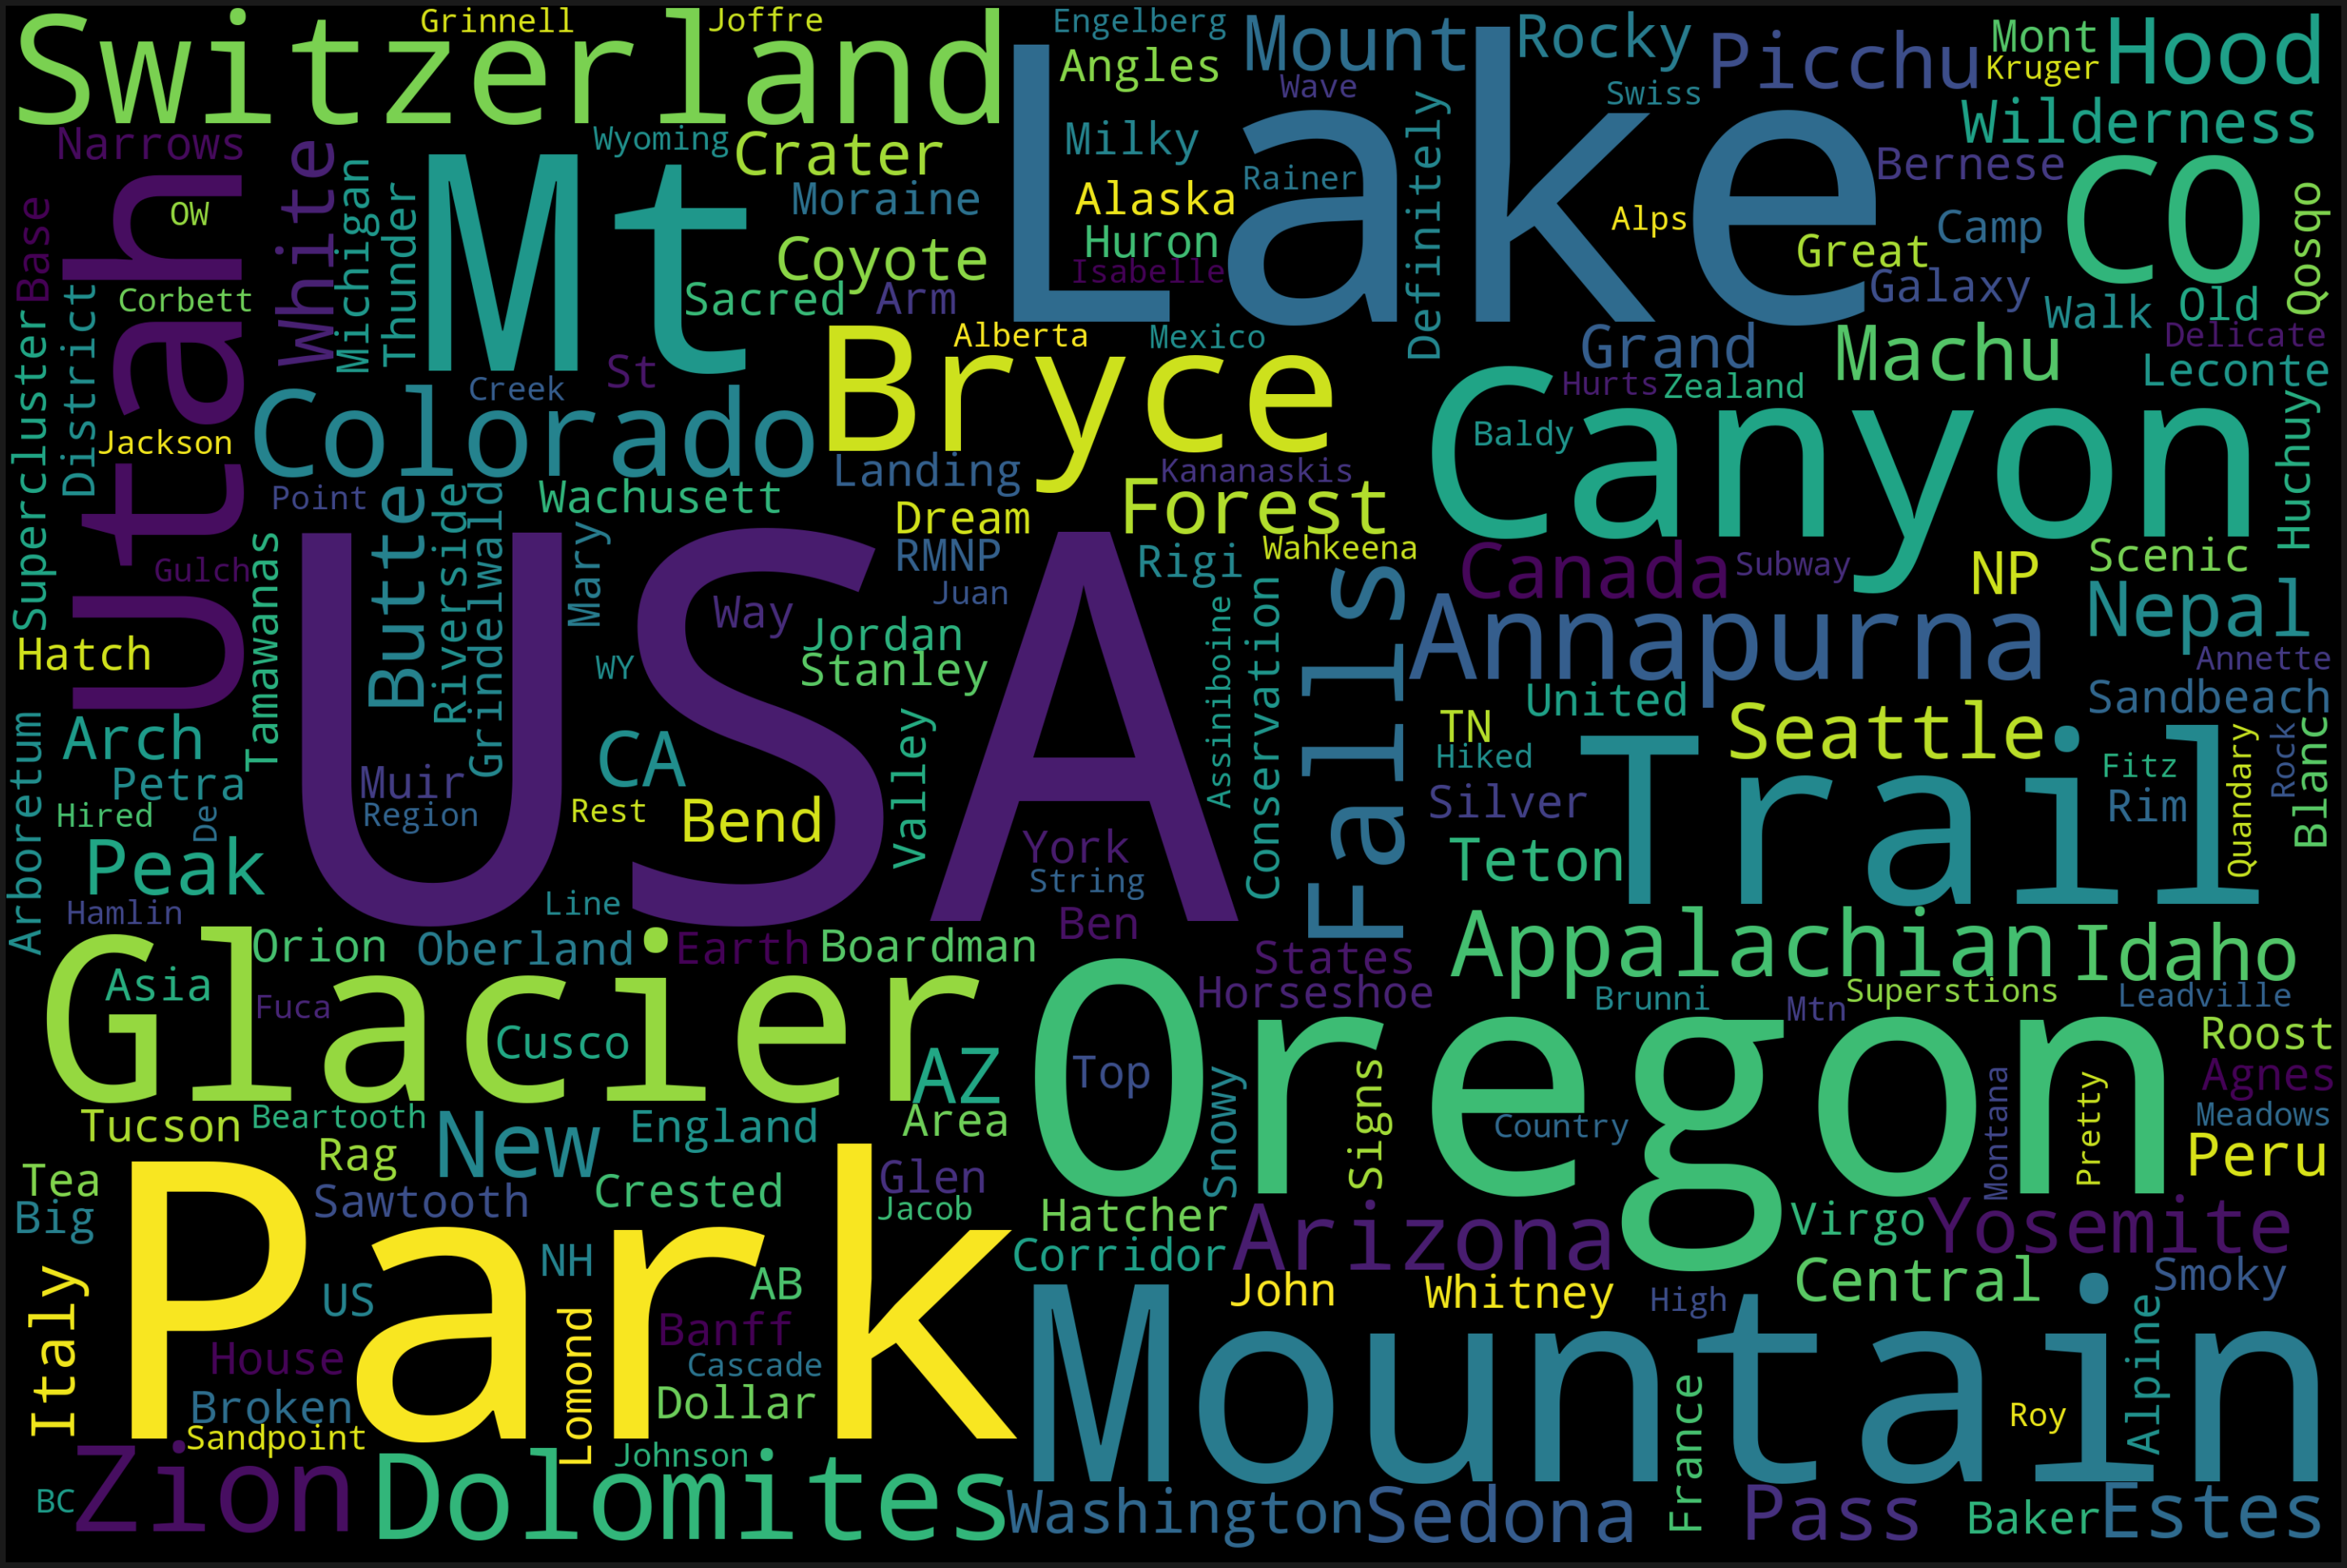

In [59]:
top = final.sort_values('score', ascending=False).head(100)
text = " ".join(title for title in top['extracted_0'])
stopwords = set(STOPWORDS)
stopwords.update(["national", "state"])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stopwords).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Let's look at the score, which shows how many "upvotes" a particular submission received.  This is a proxy for how popular each submission was.

There is one exceptionally high outlier from a plea for a missing hiker.  since this outlier is over three times further out than any other point, we are going to remove it.

In [60]:
final.describe()

score           lat           lon
count  30898.000000  30898.000000  30898.000000
mean      98.010810     37.943294    -77.467856
std      372.979921     16.160806     63.533325
min        0.000000    -82.862752   -166.808055
25%        2.000000     36.050088   -116.084567
50%       11.000000     39.601392   -102.339691
75%       40.000000     45.427110    -74.005973
max    30477.000000     78.223172    178.369200

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2430b860>]],
      dtype=object)

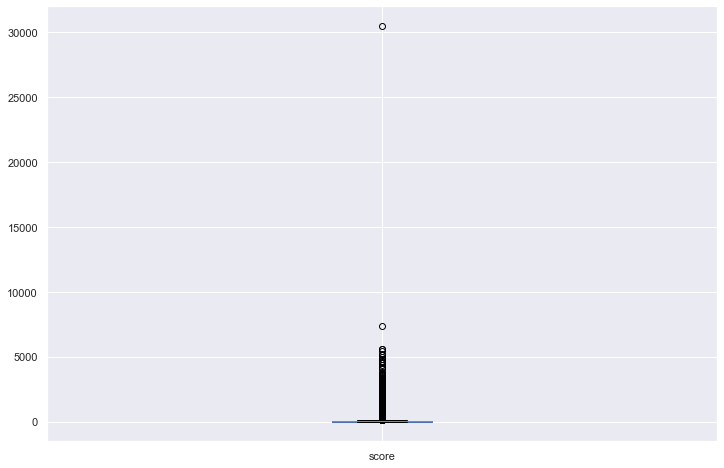

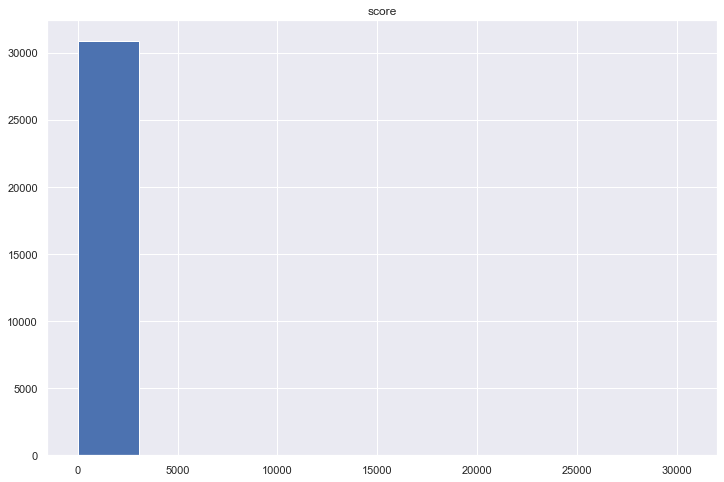

In [61]:
final.boxplot('score')
final.hist('score')

In [62]:
final[final['score'] >10000]
#final.drop(26480, inplace=True)
final.drop(9492, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a228e3128>]],
      dtype=object)

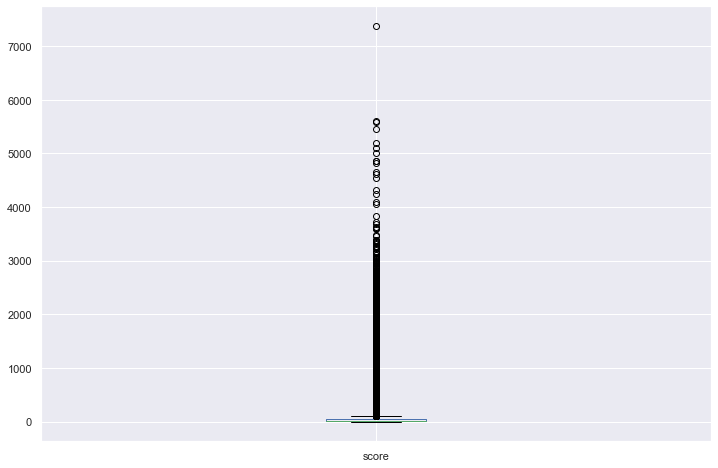

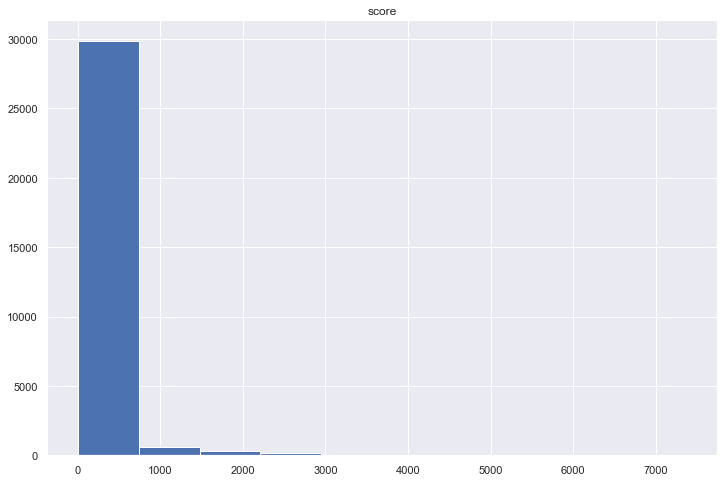

In [63]:
final.boxplot('score')
final.hist('score')

There numerous posts that only get a few upvotes while a small number can get thousands.  The median upvote score is only 11, while the average is 97, showing a significant right skew.  Maybe we should plot the most popular submissions to see if there are any differences.

### A look at the temporal aspect...

In [64]:
final['Year of Submission'] = final['dt_time'].dt.year
final['Month of Submission'] = final['dt_time'].dt.month
final['Day of Submission'] = final['dt_time'].dt.date

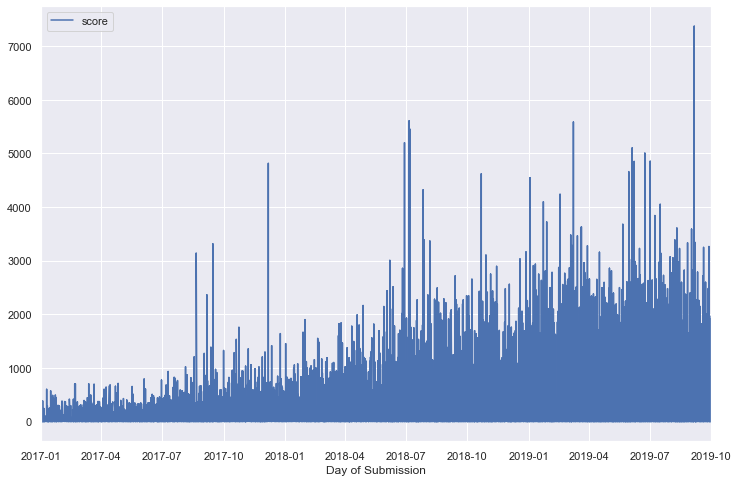

In [65]:
final.plot(x='Day of Submission', y='score', figsize=(12,8))

Text(0.5, 1.0, 'Count of Submissions by Month, Colored by Year')

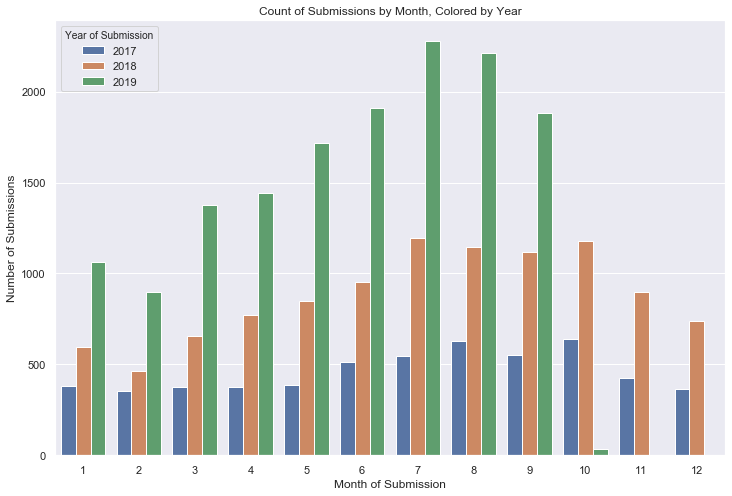

In [66]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x='Month of Submission',  hue='Year of Submission', data=final)
plt.ylabel('Number of Submissions')
plt.title('Count of Submissions by Month, Colored by Year')


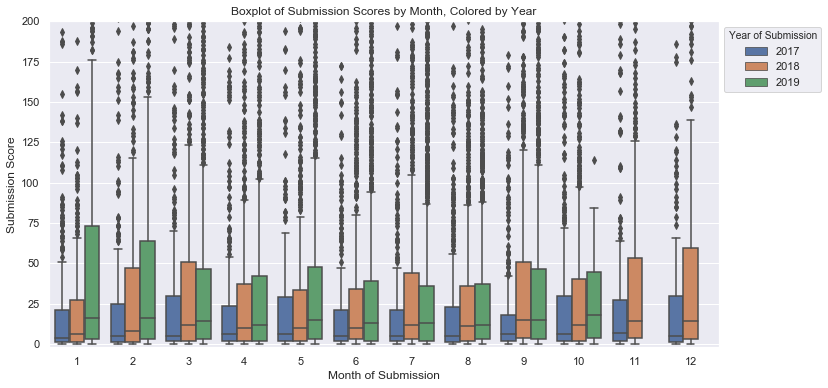

In [67]:
plt.figure(figsize=(12,6))
ax = sns.boxplot(x='Month of Submission', y='score',  hue='Year of Submission', data=final)
plt.ylim(bottom=-2)
plt.ylim(top=200)
plt.ylabel('Submission Score')
plt.title('Boxplot of Submission Scores by Month, Colored by Year')
ax.get_legend().set_bbox_to_anchor((1, 1))

In [68]:
season_dict = {1:'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 
               6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall',
              11: 'Fall', 12: 'Winter'}

final['Season'] = final['Month of Submission'].map(season_dict)

season_color = {'Winter':'blue', 'Spring':'green', 'Summer':'yellow','Fall':'brown'}
final['season_color'] = final['Season'].map(season_color)

Text(0.5, 1.0, 'Count of Submissions by Month, Colored by Season')

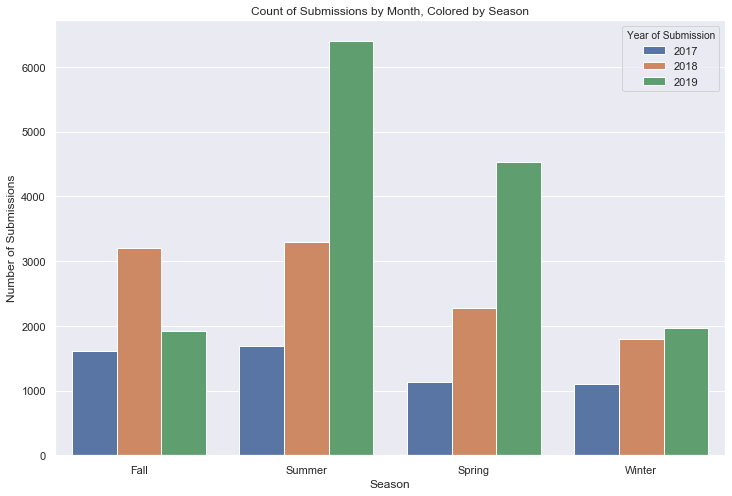

In [69]:
sns.countplot(hue='Year of Submission',  x='Season', data=final)
plt.ylabel('Number of Submissions')
plt.title('Count of Submissions by Month, Colored by Season')

This chart is misleading in that we only have data for two months (January and February) of winter 2017.  Additionally, We only have one month (September) of fall 2019 and just two months (January and February) of winter 2019.

### What places are mentioned in the submissions?

First we'll create a dataframe of submissions that only have the United States as country.  We'll use groupby statements to get a count of total submissions and the sum of the total number of upvotes (score) for each state.  We'll also add a column for color to make plotting this data easier.  Then we'll do the same thing for all other countries, but aggregate by country.  This will allow us to compare counts across US states and countires directly.

In [70]:
us_totals = pd.DataFrame()
us = final[final['country']=='United States']

us_totals['count'] = us.groupby('administrative_area_level_1').count()['country']
us_totals['score_total'] = us.groupby('administrative_area_level_1').sum()['score']
us_totals['country'] = 'United States'
us_totals['color'] = 'blue'


In [71]:
rest_totals = pd.DataFrame()
rest = final[~final.country.isin(['United States'])]

rest_totals['count'] = rest.groupby('country').count()['score']
rest_totals['score_total'] = rest.groupby('country').sum()['score']

rest_totals['country'] = 'Other'
rest_totals['color'] = 'grey'

In [72]:
all_totals = us_totals.append(rest_totals)

Since there are so many states and countries, we'll just look at those with more than 50 total submissions.

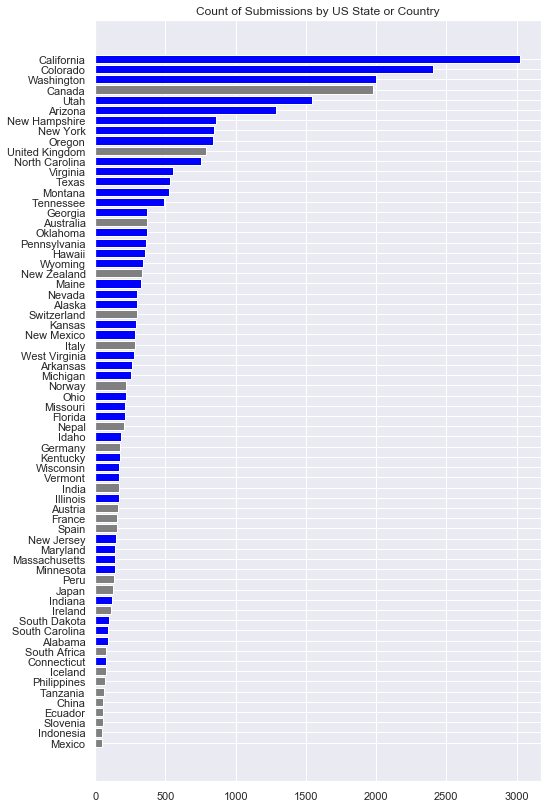

In [73]:
all_totals = all_totals.sort_values('count',ascending=True)
all_totals_subset = all_totals[all_totals['count'] > 50]
f, ax = plt.subplots(figsize=(8,14))
plt.barh(y=all_totals_subset.index, width=all_totals_subset['count'], 
         color=all_totals_subset['color'])
plt.title('Count of Submissions by US State or Country')
plt.show()

We'll now use the same dataframe to print the top states and countries by total upvotes.  Here we'll set a threshold of 100.

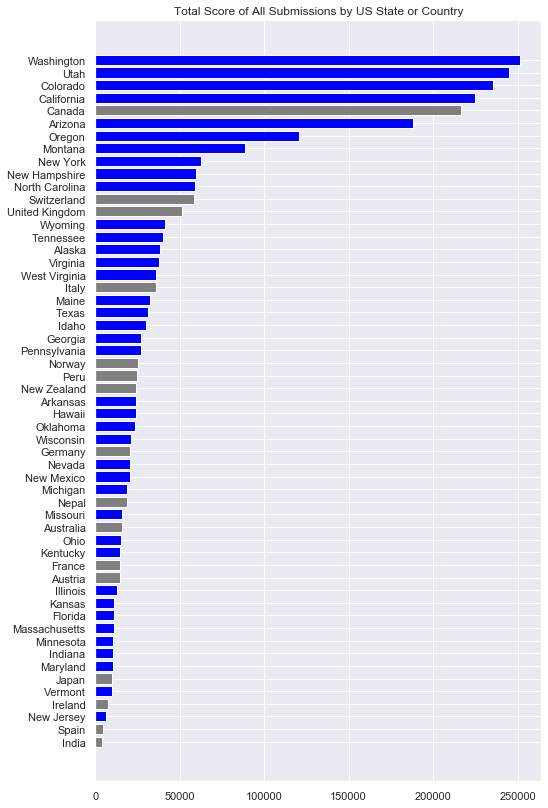

In [74]:
all_totals = all_totals.sort_values('score_total',ascending=True)
all_totals_subset = all_totals[all_totals['count'] > 100]
f, ax = plt.subplots(figsize=(8,14))
plt.barh(y=all_totals_subset.index, width=all_totals_subset['score_total'], 
         color=all_totals_subset['color'])
plt.title('Total Score of All Submissions by US State or Country')
plt.show()

### Plotting places from the submissions

Next, we'll use geopandas and some shapefiles to plot the submissions globally and across the US.

In [75]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [76]:
world_gdf = gpd.read_file('ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
world_gdf = world_gdf[world_gdf['NAME'] != 'Antarctica']

Lets normalize the 'score' fields so we can use it to plot size.  We'll then multiply it with a scalar so it works with the size of our map.  We then use geopanda's point function to convert our latitudes and longitudes.

In [77]:
final['normed_score'] = 150*(final['score']-min(final['score']))/(max(final['score'])-min(final['score']))
sites = gpd.GeoDataFrame(final, geometry=[Point(x, y) 
                                           for x, y in zip(final['lon'],final['lat'])])


(-197.99999999999991, 198.00000000000003, -91.28986091564178, 91.9638131086497)

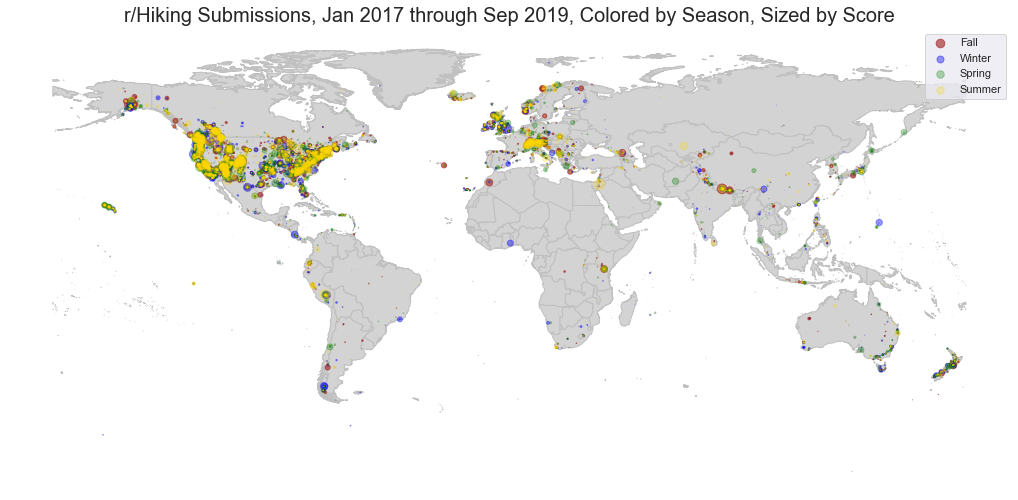

In [78]:
ax = world_gdf.plot(color='lightgrey', edgecolor='silver', figsize=(18,10))

sites[sites['Season']=='Fall'].plot(ax=ax, marker='o', color='brown', markersize='normed_score', 
                                    label='Fall',alpha=.65)
sites[sites['Season']=='Winter'].plot(ax=ax, marker='o', color='blue', markersize='normed_score', 
                                      label='Winter',alpha=.4)
sites[sites['Season']=='Spring'].plot(ax=ax, marker='o', color='green', markersize='normed_score',
                                      label='Spring',alpha=.3)
sites[sites['Season']=='Summer'].plot(ax=ax, marker='o', color='gold', markersize='normed_score', 
                                      label='Summer',alpha=.25)
ax.set_aspect('equal')
ax.legend()
ax.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
ax.axis('off')

Great!  We can finally see where our most popular photos were taken!  As suspected, there is a huge bias to the United States.



## Can we plot just the Continental United States?

We'll make the same conversions but use a different scalar for the normalized score since the map size is different.

In [79]:
final['normed_score'] = 800*(final['score']-min(final['score']))/(max(final['score'])-min(final['score']))
sites = gpd.GeoDataFrame(final, geometry=[Point(x, y) 
                                           for x, y in zip(final['lon'],final['lat'])])

In [80]:
states_provinces_gdf = gpd.read_file('ne_10m_admin_1_states_provinces_lakes/ne_10m_admin_1_states_provinces_lakes.shp')
states_gdf = states_provinces_gdf[states_provinces_gdf.admin.isin(['United States of America'])]
cont_us = states_gdf[~states_gdf.name.isin(['Hawaii', 'Alaska'])]

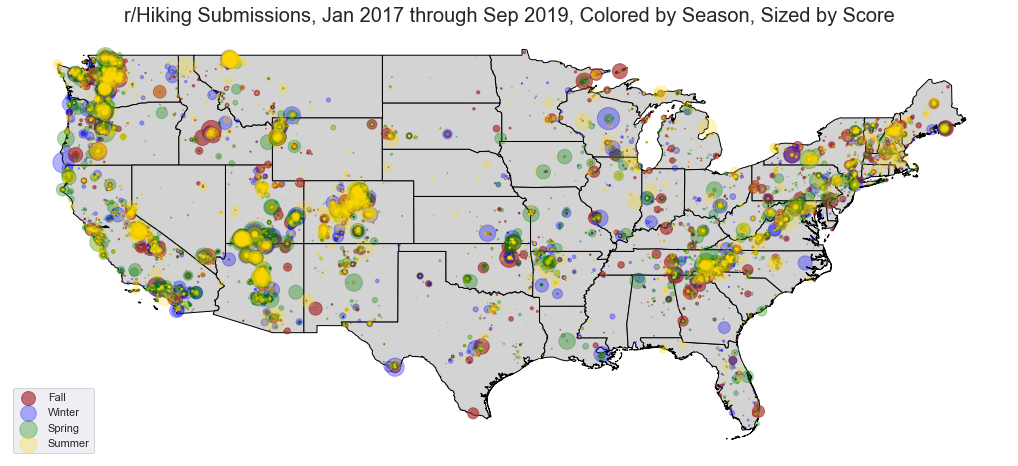

In [81]:
cont_us_map = cont_us.plot(color='lightgrey', edgecolor='black', figsize=(18,12))
cont_us_map.set_aspect('equal')
us_sites = sites[(sites['country'] == 'United States')]
cont_us_sites = us_sites[~us_sites.administrative_area_level_1.isin(['Hawaii', 'Alaska']) &
                        (us_sites['lat'] < 60)]
cont_us_sites[cont_us_sites['Season']=='Fall'].plot(ax=cont_us_map, label='Fall',marker='o',
                                                    markersize='normed_score', color='brown', alpha=.65)
cont_us_sites[cont_us_sites['Season']=='Winter'].plot(ax=cont_us_map, label='Winter', marker='o', 
                                                      markersize='normed_score', color='blue', alpha=.3)
cont_us_sites[cont_us_sites['Season']=='Spring'].plot(ax=cont_us_map, label='Spring', marker='o', 
                                                     markersize='normed_score', color='green', alpha=.3)
cont_us_sites[cont_us_sites['Season']=='Summer'].plot(ax=cont_us_map, label='Summer', marker='o', 
                                                      markersize='normed_score', color='gold', alpha=.25)

cont_us_map.axis('off')
cont_us_map.legend()
cont_us_map.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
#plt.savefig('post.png', format='png', dpi=1200, transparent=True)
plt.show()


### Individual Plots for Each Season

Even with adjusted alpha values, the layering of all four seasons can make the last season plotted (in this case Summer) seem more prevalent.  The following four maps show each season on its own.  As a future option, I could make the map interactive so the user can adjust the layers themselves.

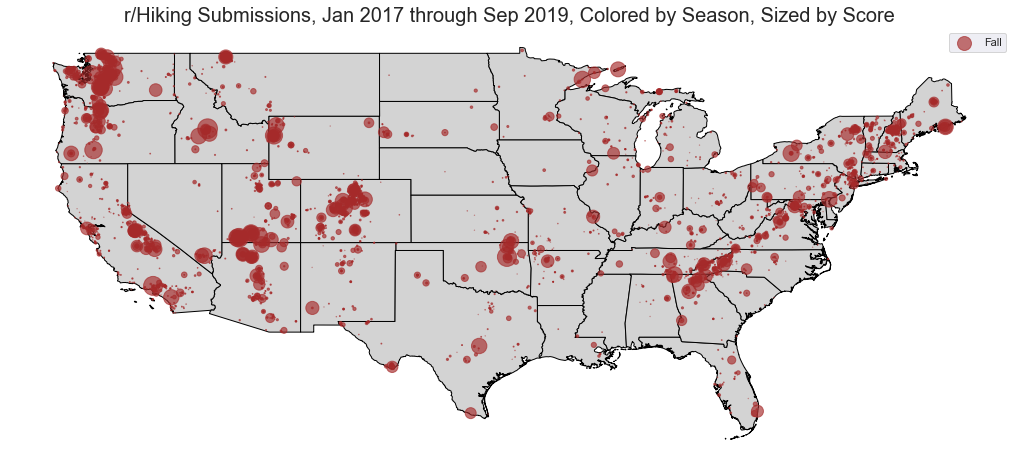

In [82]:
cont_us_map = cont_us.plot(color='lightgrey', edgecolor='black', figsize=(18,12))
cont_us_map.set_aspect('equal')

cont_us_sites[cont_us_sites['Season']=='Fall'].plot(ax=cont_us_map, label='Fall',marker='o',
                                                    markersize='normed_score', color='brown', alpha=.65)

cont_us_map.axis('off')
cont_us_map.legend()
cont_us_map.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
plt.show()

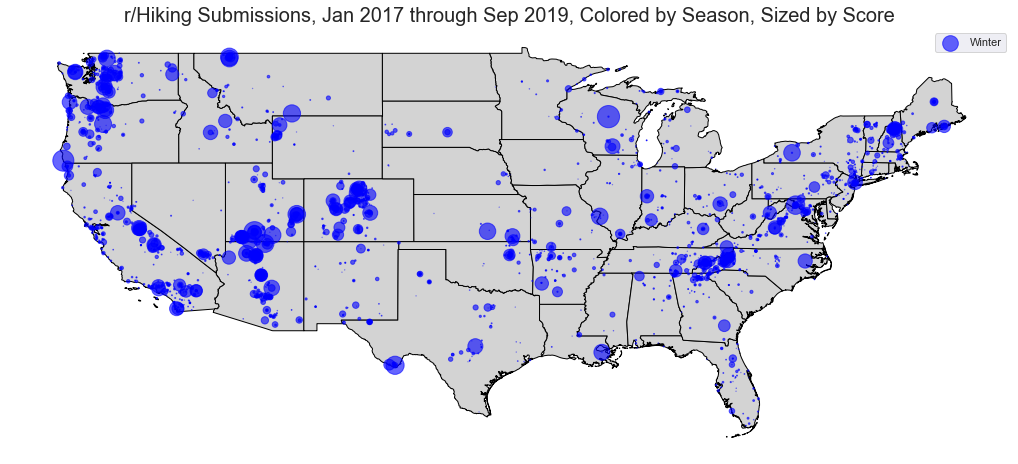

In [83]:
cont_us_map = cont_us.plot(color='lightgrey', edgecolor='black', figsize=(18,12))
cont_us_map.set_aspect('equal')
cont_us_sites[cont_us_sites['Season']=='Winter'].plot(ax=cont_us_map, label='Winter', marker='o', 
                                                      markersize='normed_score', color='blue', alpha=.6)
cont_us_map.axis('off')
cont_us_map.legend()
cont_us_map.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
plt.show()

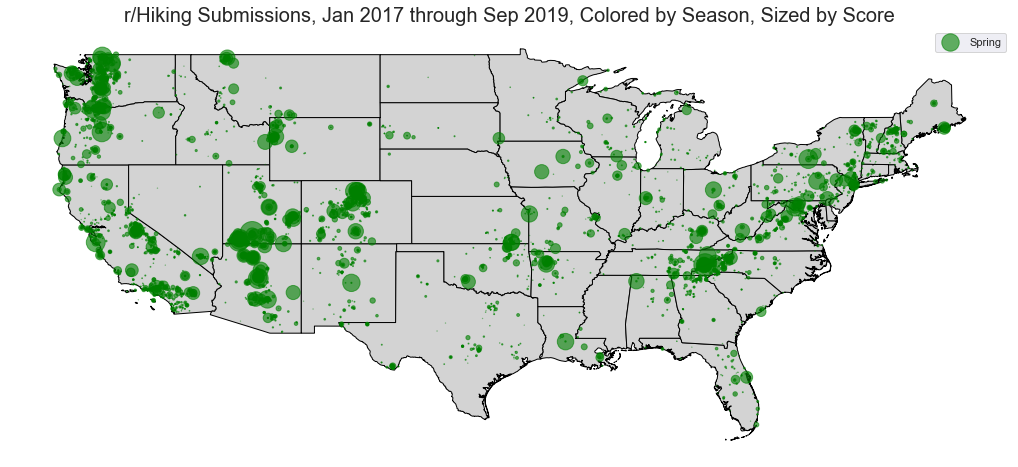

In [84]:
cont_us_map = cont_us.plot(color='lightgrey', edgecolor='black', figsize=(18,12))
cont_us_map.set_aspect('equal')
cont_us_sites[cont_us_sites['Season']=='Spring'].plot(ax=cont_us_map, label='Spring', marker='o', 
                                                     markersize='normed_score', color='green', alpha=.6)
cont_us_map.axis('off')
cont_us_map.legend()
cont_us_map.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
plt.show()



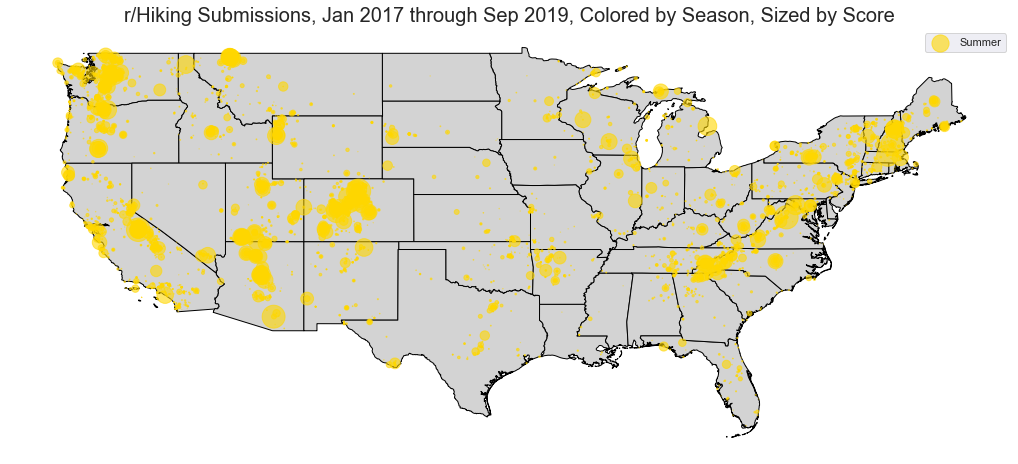

In [85]:
cont_us_map = cont_us.plot(color='lightgrey', edgecolor='black', figsize=(18,12))
cont_us_map.set_aspect('equal')
cont_us_sites[cont_us_sites['Season']=='Summer'].plot(ax=cont_us_map, label='Summer', marker='o', 
                                                      markersize='normed_score', color='gold', alpha=.6)
cont_us_map.axis('off')
cont_us_map.legend()
cont_us_map.set_title('r/Hiking Submissions, Jan 2017 through Sep 2019, Colored by Season, Sized by Score', fontsize=20)
plt.show()

## Choropleth Maps

We can take a look at just the US with a choropleth map as well.  We'll make two; one for count of submissions and another for total score.

(-127.62674177639992, -63.9997819315999, 23.30120060887725, 50.61084143157933)

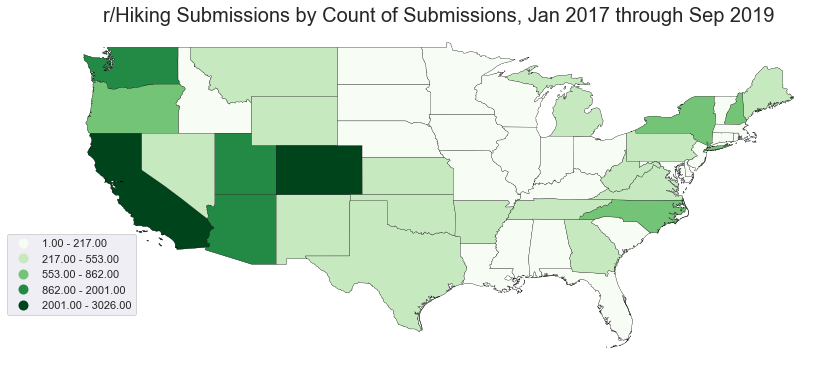

In [86]:
merged = pd.merge(cont_us, us_totals,  how='right', right_index=True, 
                  left_on='name')

ax = cont_us.plot(edgecolor='black', linewidth = .15, color='silver', figsize=(14,10))
states_to_plot = merged[['name','count','geometry']]
states_to_plot = states_to_plot[~states_to_plot['name'].isin(['Hawaii', 'Alaska'])]
states_to_plot.plot(ax=ax, column='count', cmap='Greens', scheme='fisher_jenks', k=5,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Count of Submissions, Jan 2017 through Sep 2019', fontsize=20)
ax.axis('off')

(-127.62674177639992, -63.9997819315999, 23.30120060887725, 50.61084143157933)

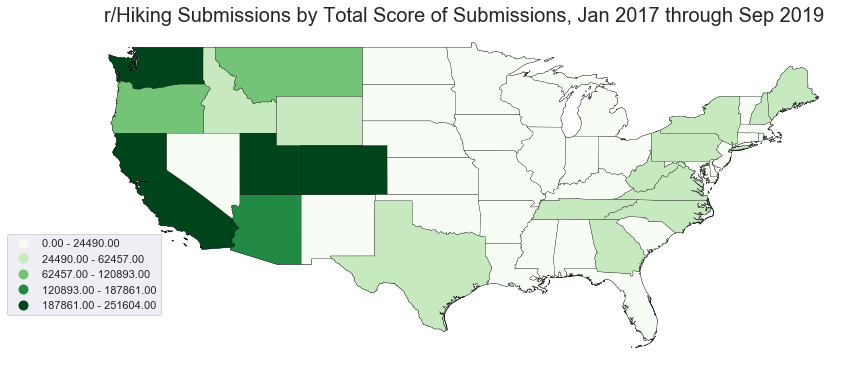

In [87]:
merged = pd.merge(cont_us, us_totals,  how='right', right_index=True, 
                  left_on='name')

ax = cont_us.plot(edgecolor='black', linewidth = .45, color='silver', figsize=(14,10))
states_to_plot = merged[['name','score_total','geometry']]
states_to_plot = states_to_plot[~states_to_plot['name'].isin(['Hawaii', 'Alaska'])]
states_to_plot.plot(ax=ax, column='score_total', cmap='Greens', scheme='fisher_jenks', k=5,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Total Score of Submissions, Jan 2017 through Sep 2019', fontsize=20)
ax.axis('off')

## Heat Map of the World!

In [88]:
world_gdf_for_merge = world_gdf[['ADMIN','geometry']]
world_gdf_for_merge = world_gdf_for_merge.rename(columns={'ADMIN':'name'})
states_gdf_for_merge = states_gdf[['name','geometry']]
combo_gdf = world_gdf_for_merge.append(states_gdf_for_merge)

merged = pd.merge(combo_gdf, all_totals,  how='right', right_index=True, 
                  left_on='name')

Text(0.5, 1, 'r/Hiking Submissions by Count of Submissions, Jan 2017 through Sep 2019')

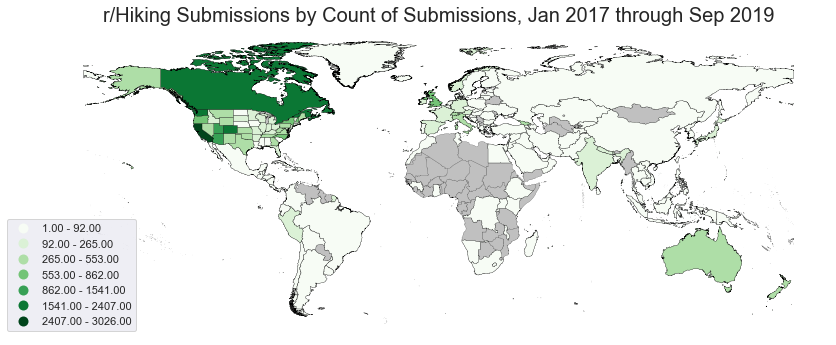

In [89]:
ax = combo_gdf.plot(edgecolor='black', linewidth = .15, color='silver', figsize=(14,10))
merged.plot(ax=ax, column='count', cmap='Greens', scheme='fisher_jenks', k=7,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Count of Submissions, Jan 2017 through Sep 2019', fontsize=20)

Text(0.5, 1, 'r/Hiking Submissions by Total Score of Submissions, Jan 2017 through Sep 2019')

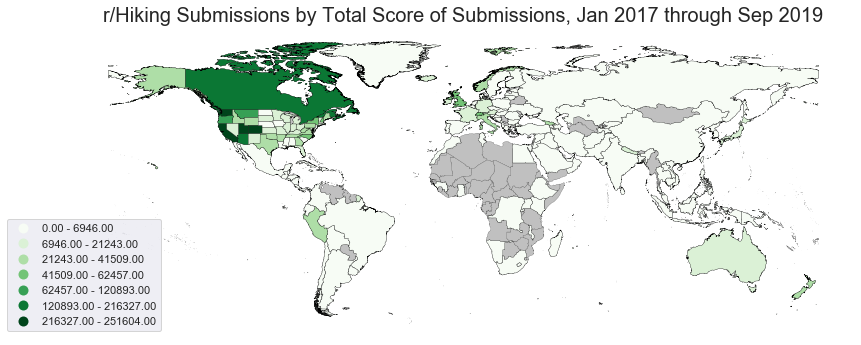

In [90]:
ax = combo_gdf.plot(edgecolor='black', linewidth = .15, color='silver', figsize=(14,10))
merged.plot(ax=ax, column='score_total', cmap='Greens', scheme='fisher_jenks', k=7,
                 legend=True, edgecolor='black', linewidth = .25, figsize=(14,10))
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.12, .4))
ax.set_title('r/Hiking Submissions by Total Score of Submissions, Jan 2017 through Sep 2019', fontsize=20)

## Key Findings And Conclusions

Overall, the r/Hiking subreddit is increasing in popularity with more submissions and upvotes year over year since 2017.  There appears to be a significant bias toward the United States, and to a lesser extent Canada.  This is to be expected on an English lanaguage sub-reddit, but the scale of it was not anticipated.  

For geographic trends in the US, there is a high concentration across California, the state with the highest number of submissions and the third highest total score of upvotes.  However, Washington was remarkable for having the highest total score while ranking third on number of submissions.  This suggests that submissions featuring hiking destinations in Washington on average score higher than submissions from California.  There are also hotspots near concentrations of national parks and mountian ranges, as well as along coasts.

I analyzed seasonality to look for trends in both time and space for the four different seasons.  Overall, the summer and spring are more popular times for submissions.  However, I did not observe any strong trends spatially based on season.  A more detailed analysis of state by state totals and averages across the four season could identify unobserved trends.  Additionally, complete data for each season year over year would make this comparison more effective.

In conclusion, if you want a high scoring post on Reddit's r/Hiking, your best bet is to fly out to the Pacific Northwest and get some excellent photos of the beautiful scenery in the late Summer.  Judging from the wordcloud, submissions with "Park", "Lake", and "Trail" in the title have often appeared in the top 100.